In [1]:
!git clone -q -b feature/demo https://github.com/avsthiago/deepbee-source.git
%cd deepbee-source/notebooks/

/content/deepbee-source/notebooks


In [43]:
!pip install -q -r ../requirements.txt

In [3]:
# Download the segmentation model
!gdown -q 17KyogWBf61lKfmIW1AVPj_0Hd-ngVX8A -O models/

In [12]:
# Download the dataset
!gdown -q 17aa1xCnM0CsHjLrWzDmAJD852QdEa0T_ -O data/raw/
!unzip -q data/raw/sample-images.zip -d data/raw/
!rm data/raw/sample-images.zip !rm -rf data/raw/_*

In [6]:
import numpy as np
import cv2
import sys
from keras.saving import load_model
import matplotlib.pyplot as plt
from utils import detection_scale_invariant
%matplotlib inline

### Load image

In [13]:
img = cv2.imread("data/raw/BEE_HOPE GIMONDE 2016_06_30 BL3_G DSC_2864.jpeg")

In [14]:
def convert_bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

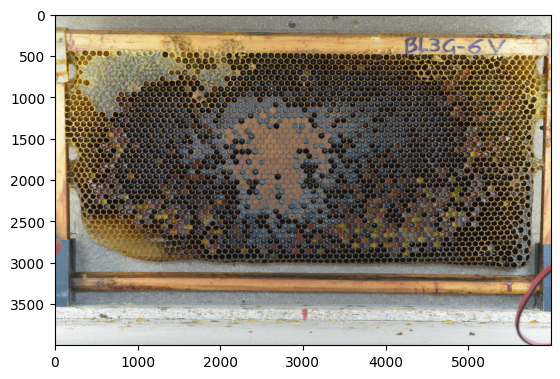

In [15]:
plt.imshow(convert_bgr_to_rgb(img))
plt.show()

### Set a fixed image size to process images with different shapes

In [16]:
original_shape = img.shape[:2]
print(f"Original Shape: {original_shape}")

if original_shape != (4000, 6000):
    img = cv2.resize(img, (6000, 4000))

Original Shape: (4000, 6000)


### Add mirrored border

In [17]:
reflect = cv2.copyMakeBorder(img, 184, 184, 148, 148, cv2.BORDER_REFLECT)

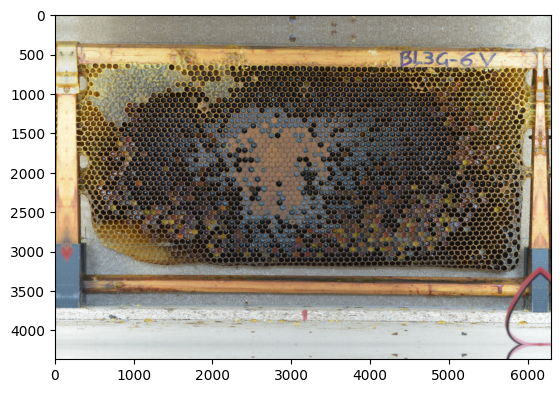

In [18]:
plt.imshow(convert_bgr_to_rgb(reflect))
plt.show()

### Predefine the slices used to create the tiles

In [19]:
pos_x = np.arange(0, 5785,482)
pos_y = np.arange(0, 3857,482)
slices = [np.s_[y[0]:y[1],x[0]:x[1]] for x in zip(pos_x, pos_x + 512) for y in zip(pos_y, pos_y + 512)]
print(f"Exemples of slices: {slices[:2]}")

Exemples of slices: [(slice(0, 512, None), slice(0, 512, None)), (slice(482, 994, None), slice(0, 512, None))]


### Extract all the tiles and resize them to 128x128px (model input shape)

In [20]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

X = np.array([cv2.resize(reflect[sl], (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
              for sl in slices], dtype=np.uint8)

In [21]:
# Plotting the tiles extracted
def plot_tiles(X, func) -> None:
    f, axarr = plt.subplots(9,13,  figsize=(10,10))
    f.subplots_adjust(hspace=-0.8, wspace=.1)
    img_index = 0

    for i in range(13):
        for j in range(9):
            axarr[j,i].imshow(func(X[img_index]), vmin=0, vmax=255)
            axarr[j,i].axis('off')
            img_index += 1

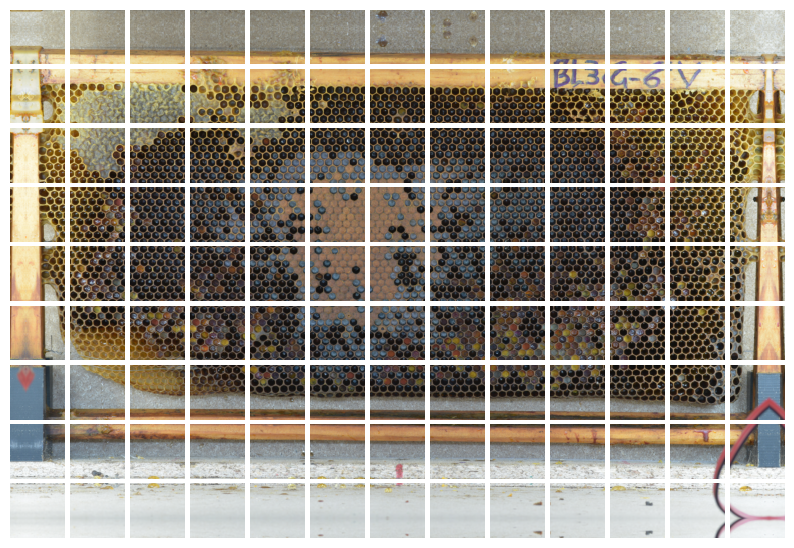

In [22]:
plot_tiles(X, convert_bgr_to_rgb)

### Load the semantic segmentation model and process the tiles

In [24]:
# load the model
model = load_model("models/segmentation_model.keras")

In [29]:
# predict the tiles
# if you are running the model trained in the previous notebook use the line below
#predictions = model.predict(X/255, verbTrue)
predictions = model.predict(X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


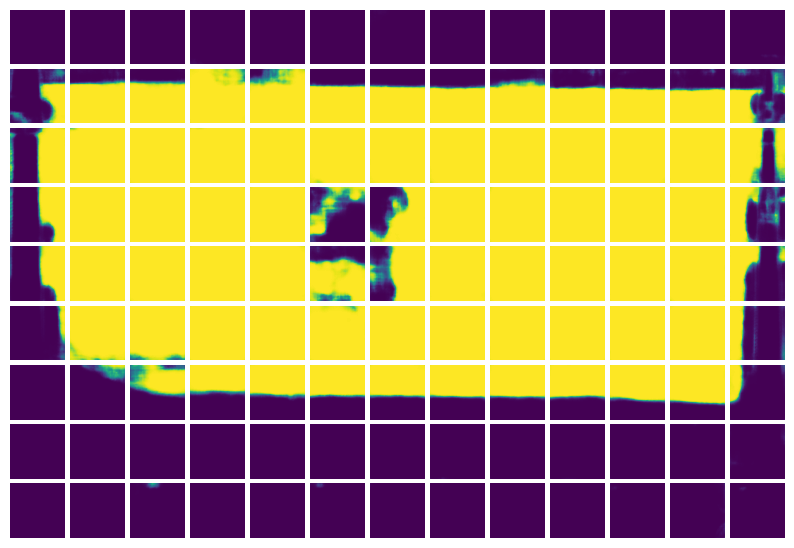

In [30]:
# show the predicted tiles
plot_tiles(predictions * 255, np.squeeze)

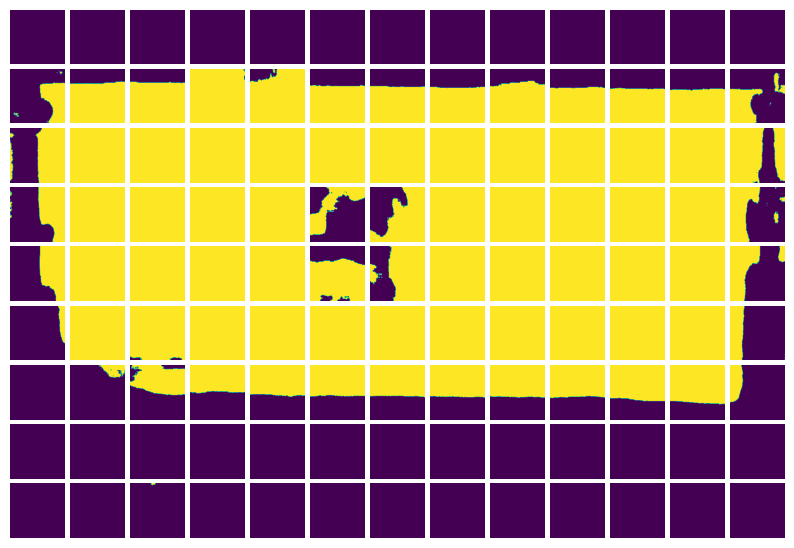

In [31]:
# threshold the outputs and convert them to uint8
predictions = (predictions > 0.5).astype(np.uint8) * 255
# show the thresholded tiles
plot_tiles(predictions, np.squeeze)

### Tiles reassemble

In [32]:
# image size after removing the offset among the tiles
IMG_WIDTH_DEST = 482
IMG_HEIGHT_DEST = 482

# empty array to store the resized tiles
RESULT_Y = np.zeros((len(predictions), IMG_HEIGHT_DEST, IMG_WIDTH_DEST, 1), dtype=np.uint8)

# resize the tiles and remove the offsets
for j, x in enumerate(predictions):
    RESULT_Y[j] = np.expand_dims(cv2.resize(x,(512, 512),
                                 interpolation=cv2.INTER_LINEAR)[15:497,15:497],
                                 axis=-1)

# reassemble the tiles and remove the mirrored border
reassembled_segmentation = np.squeeze(np.hstack([np.vstack(i)
                                                 for i in np.split(RESULT_Y, 13)]))[169:4169, 133:6133]

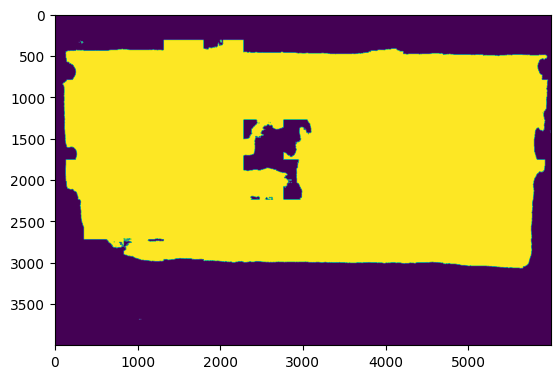

In [33]:
plt.imshow(reassembled_segmentation)
plt.show()

### Filter only the biggest segmentation area

In [34]:
# find all countours in the image
contours, _ = cv2.findContours(reassembled_segmentation, mode=1, method=2)
# filter the biggest one
max_cnt = contours[np.argmax(np.array([cv2.contourArea(i) for i in contours]))]
# empty the segmentation image
reassembled_segmentation *= 0
# redraw the biggest countour filled
cv2.drawContours(reassembled_segmentation, [max_cnt], 0, (255,255,255), -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

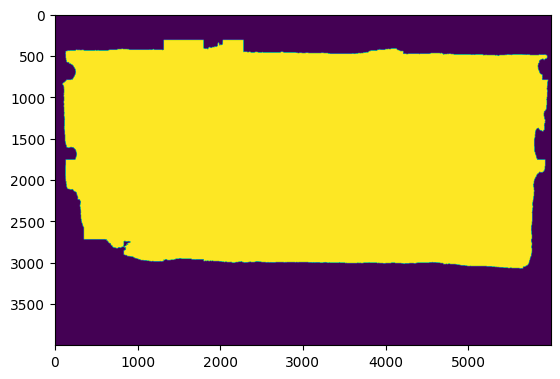

In [35]:
plt.imshow(reassembled_segmentation)
plt.show()

### Clip the segmentation to improve the cells detection performance

In [36]:
x,y,w,h = cv2.boundingRect(max_cnt)
# create a region of interest from the max countour bounding rectangle
roi = np.copy(img[y:y+h,x:x+w])

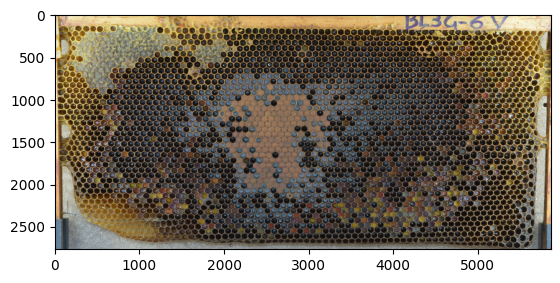

In [37]:
plt.imshow(convert_bgr_to_rgb(roi))
plt.show()

### Detect the cells

In [38]:
# detect the cells
cells = detection_scale_invariant.detect_cells(roi)
# put the cells in the original place
cells[:,0] += x
cells[:,1] += y

In [39]:
def draw_cells(image, cells):
    for c in cells:
        image = cv2.circle(image, (c[0], c[1]), (c[2]), (0, 255, 0), 6)
    return image

In [40]:
img_cells = draw_cells(np.copy(img), cells)

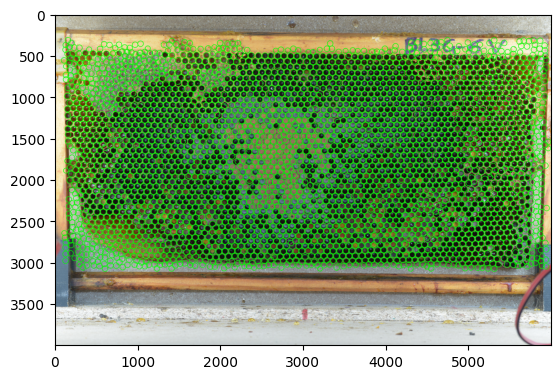

In [41]:
plt.imshow(convert_bgr_to_rgb(img_cells))
plt.show()

### Remove detections that does not lay over the segmentation

In [42]:
cells = cells[reassembled_segmentation[cells[:,1], cells[:,0]] > 0]

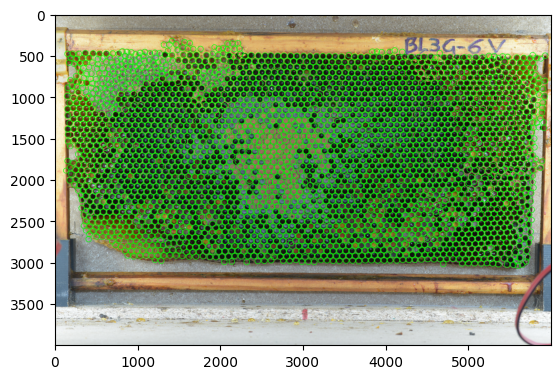

In [43]:
img_cells = draw_cells(np.copy(img), cells)
plt.imshow(convert_bgr_to_rgb(img_cells))
plt.show()